# **Setup**

In [1]:
# Auto-reload edited scripts
%load_ext autoreload
%autoreload 2

# Import training function
from ngram_train.word2vec import train_models, evaluate_models, plot_evaluation_results
from ngram_prep.utilities.notebook_logging import setup_notebook_logging

In [ ]:
src_path = '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files'

setup_notebook_logging(
    workflow_name="training_workflow",
    console=False
)

train_models(
    corpus_path=src_path,
    dir_suffix='test',
    years=(2019, 2019),
    weight_by=('none',),
    vector_size=(100, 200,),
    window=(4,),
    min_count=(1,),
    approach=('cbow', 'skipgram'),
    epochs=(10, 15, 20, 25),
    max_parallel_models=8,
    workers_per_model=5,
    mode="restart",
    unk_mode="strip",
    use_corpus_file=True
)

Restart mode: Removing existing models directory: /vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Restart mode: Removing existing logs directory: /vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/training


WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-05 21:12:35

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             .../edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5grams_pivoted.db
Model directory:      /vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Log directory:        .../edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/training
Parallel models:      8

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                2019–2

In [4]:
mod_path = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files'

setup_notebook_logging(
    workflow_name="evaluation_workflow",
    data_path=mod_path,
    console=False
)

evaluate_models(
    model_dir=mod_path,
    dir_suffix='test',
    eval_dir=mod_path,
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=False
)


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-05 16:57:12

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Evaluation file:      ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
Log directory:        ...dk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...miniforge/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...orge/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 8 models to evaluate



Evaluating models: 100%|██████████| 8/8 [00:00<00:00, 23.21 models/s]


Evaluation Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models evaluated:     8
Results saved to:     ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



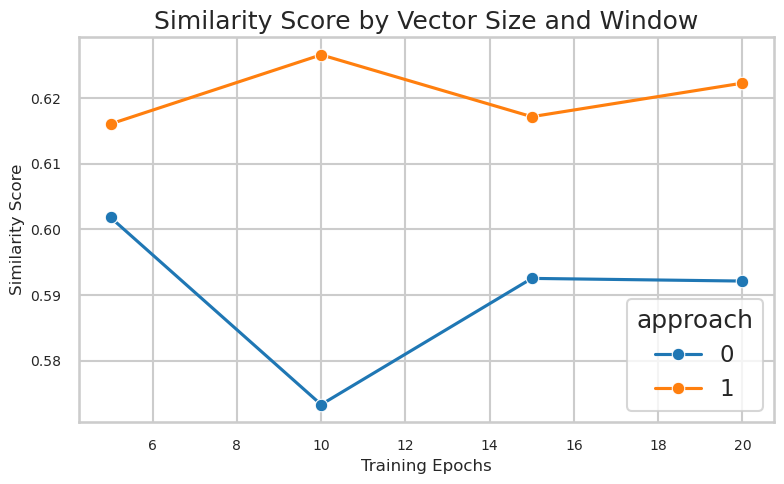

,model,year,weight_by,vector_size,window,min_count,approach,epochs,similarity_score
0,w2v_y2019_wbnone_vs100_w004_mc001_sg1_e010.kv,2019,none,100,4,1,1,10,0.626651
1,w2v_y2019_wbnone_vs100_w004_mc001_sg0_e020.kv,2019,none,100,4,1,0,20,0.592128
2,w2v_y2019_wbnone_vs100_w004_mc001_sg0_e005.kv,2019,none,100,4,1,0,5,0.601842
3,w2v_y2019_wbnone_vs100_w004_mc001_sg0_e015.kv,2019,none,100,4,1,0,15,0.592535
4,w2v_y2019_wbnone_vs100_w004_mc001_sg1_e015.kv,2019,none,100,4,1,1,15,0.617209
5,w2v_y2019_wbnone_vs100_w004_mc001_sg1_e020.kv,2019,none,100,4,1,1,20,0.622333
6,w2v_y2019_wbnone_vs100_w004_mc001_sg0_e010.kv,2019,none,100,4,1,0,10,0.573277
7,w2v_y2019_wbnone_vs100_w004_mc001_sg1_e005.kv,2019,none,100,4,1,1,5,0.616104


In [6]:
eval_file = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=eval_file,
    metric='similarity_score',
    x_vars=['epochs', 'approach'],
    plot_type='line',
    plot_title='Similarity Score by Vector Size and Window'
)

In [ ]:
eval_file = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=eval_file,
    metric='similarity_score',
    x_vars=['vector_size', 'window'],
    plot_type='contour',
    plot_title='Similarity Score: Vector Size vs Window'
)

In [ ]:
eval_file = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=eval_file,
    metric='similarity_score',
    x_vars=['epochs', 'min_count'],
    plot_type='surface',
    plot_title='Similarity Score: Epochs vs Min Count'
)

In [ ]:
eval_file = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=eval_file,
    metric='similarity_score',
    x_vars=['epochs', 'weight_by'],
    plot_type='line',
    plot_title='Similarity Score by Epochs and Weighting Method'
)